In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.optimize import minimize
from scipy.optimize import show_options
from scipy.ndimage import gaussian_filter

import numpy as np
import functools

import ehtim as eh

import matplotlib.cm as cm
from matplotlib import pyplot as plt

Welcome to eht-imaging! v 1.2.2 



## Overview

This notebook serves as a personal walkthrough of [Chael et al. (2018)](https://arxiv.org/pdf/1803.07088.pdf), which details methods to recover astronomical images from Very Large Baseline Interferometry (VLBI) measurements. These measurements, which are correlations between pairs of antenna, sample the Fourier transform of the intensity distribution of the source object at one particular wavelength. Unfortunately, this sampling is extremely sparse and prone to both multiplicative noise (from the atmosphere) and additive, thermal noise. Computational imaging techniques, or more generally inverse problem techniques, can be used to get around this.

If we develop a forward model of the problem (how the intensity distribution gets mapped to the set of Fourier transform measurements), we can create a cost function constraining a recovered distribution's "closeness" to our measurements. (Additional assumptions in the form of regularizers help reduce the effect of noise.) We can then solve this cost function iteratively using gradient descent to obtain an estimate of the observed object's intensity distribution.

Much of this code follows the structure of the functions found in `imager_funcs` in the `ehtim` repository.

### Imaging

We use the `ehtim` library to load an image and a telescope array and create a set of corrupted visibility measurements.

Loading text image:  ./models/avery_sgra_eofn.txt


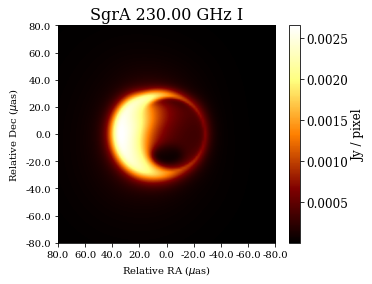

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 


In [3]:
# We load an object and observe it, obtaining a set of (corrupted) visibilities.

# Available model names
# avery_m87_1_eofn.txt
# avery_m87_2_eofn.txt
# avery_sgra_eofn.txt
# howes_m87.txt
# jason_mad_eofn.txt
# jason_mri_eofn.txt
# roman_eofn.txt
# rowan_m87.txt

im  = eh.image.load_txt('./models/avery_sgra_eofn.txt') # The object
eht = eh.array.load_txt('./arrays/EHT2017.txt')         # The antenna array

im.display() # Display the object

tint_sec  = 30  # Integration time (s)
tadv_sec  = 300 # Imaging cadence (s)
tstart_hr = 0   # Start time (h)
tstop_hr  = 24  # End time (h)
bw_hz     = 2e9 # Bandwidth (Hz)

# Observe the object; include gain variations and phase errors
obs = im.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz, sgrscat=False, ampcal=False, phasecal=False)

## Pulse functions

We want to solve for the intensity distribution $I_\lambda(l, m)$ of our object. In many computational imaging problems, this object is approximated with by a set of weighted delta functions. Such an approximation samples the spatial domain, and so creates replicas in the frequency domain. We can improve the match between our discretized intensity distribution and the true intensity distribution by instead modeling it as a set of shifted, weighted, continuous basis functions.

Another way to think of this is that our delta representation of the intensity distribution is convolved with a continuous basis function. 
The basis functions we use (rectangular and triangular functions) have a $\mathrm{sinc}$ and $\mathrm{sinc}^2$ frequency domain shape, with zeros at the maxima of the previously mentioned replicas. In this view, the inclusion of these continuous basis functions masks the replicas in the frequency domain caused by sampling the intensity distribution.

In [4]:
# 1D rectangular pulse (angular coords)
def rect(x, delta):
    if abs(x) >= delta / 2.0:
        return 0.0
    else:
        return 1.0 / delta
    
# 2D rectangular pulse (angular coords)
def rect2D(x, y, delta):
    return rect(x, delta) * rect(y, delta)
    
# 1D rectangular pulse (angular freqs)
def Rect(u, delta):
    if u == 0:
        return 1.0
    else:
        return (1.0 / (delta * np.pi * u)) * np.sin(delta * np.pi * u)
    
# 2D rectangular pulse (angular freqs)
def Rect2D(u, v, delta):
    return Rect(u, delta) * Rect(v, delta)

In [5]:
# 1D triangular pulse (angular coords)
def tri(x, delta):
    if abs(x) > delta:
        return 0.0
    else:
        return (1.0 - abs(x) / delta) / delta 
    
# 2D triangular pulse (angular coords)
def tri2D(x, y, delta):
    return tri(x, delta) * tri(y, delta)
    
# 1D triangular pulse (angular freqs)
def Tri(u, delta):
    if u == 0:
        return 1.0
    else:
        return (1.0 / (delta**2 * np.pi**2 * u**2)) * (np.sin(delta * np.pi * u))**2

# 2D triangular pulse (angular freqs)
def Tri2D(u, v, delta):
    return Tri(u, delta) * Tri(v, delta)

## Derived data and quantities

After observing our object, we can construct the derived quantities (bispectra, closure amplitudes, etc.) and direct-time Fourier transform matrix $A$. See [Chael et al. (2018)](https://arxiv.org/pdf/1803.07088.pdf) for more details. Essentially, we are creating quantities that are independent of the multiplicative atmospheric noise.

In [6]:
# After observing the object, we compute the derived terms, which are more robust to station-dependent noise

avg_time    = 0           # Time to average closure amplitudes (s)
return_type = 'rec'       # Whether to return a data frame 'df' or recarray 'rec'
count       = 'min'       # Whether to include all closure quantities or only the minimum amount, either 'min' or 'max'
debias      = True        # At low SNR, thermal noise biases the measured gains to be too large. This debiases them (see p. 4 in Chael et al.)
snrcut      = 0.0         # Flag closure amplitudes with SNR lower than this
err_type    = 'predicted' # Use either a 'predicted' error or the 'measured' error
num_samples = 1000        # The number of boostrapped samples when measuring error
round_s     = 0.1         # Accuracy of time (s)

# Produces averaged amplitudes, bispectra, closure phases, closure amplitudes, and log closure amplitudes
obs.add_all(avg_time, return_type, count, debias, snrcut, err_type, num_samples, round_s)

# Save the derived terms in arrays
V   = np.asarray(obs.data['vis'])      # Visibilities
V_A = np.asarray(obs.amp['amp'])       # Amplitudes
V_B = np.asarray(obs.bispec['bispec']) # Bispectra
psi = np.asarray(obs.cphase['cphase']) # Closure phases
V_C = np.asarray(obs.camp['camp'])     # Closure amplitudes
 
# Save the number of derived terms in arrays
N     = np.shape(V)[0]   # The number of observed visibilities
N_A   = np.shape(V_A)[0] # The number of observed amplitudes
N_B   = np.shape(V_B)[0] # Number of bispectra
N_psi = np.shape(psi)[0] # Number of closure phases
N_C   = np.shape(V_C)[0] # Number of closure amplitudes

# Save the derived term errors in arrays
sigma     = np.asarray(obs.amp['sigma'])      # Visibility errors
sigma_A   = sigma                             # Amplitude errors
sigma_B   = np.asarray(obs.bispec['sigmab'])  # Bispectra errors
sigma_psi = np.asarray(obs.cphase['sigmacp']) # Closure phase errors
sigma_C   = np.asarray(obs.camp['sigmaca'])   # Closure amplitude errors

Updated self.amp: no averaging
Updated self.amp: avg_time 0.000000 s

Updated self.bispec: no averaging
Updated self.bispec: avg_time 0.000000 s

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Diagonalizing closure phases:: type vis, count min, scan 196/196 

Updated self.cphase_diag: no averaging
updated self.cphase_diag: avg_time 0.000000 s

updated self.camp: no averaging
updated self.camp: avg_time 0.000000 s

updated self.lcamp: no averaging
updated self.logcamp: avg_time 0.000000 s

Diagonalizing log closure amplitudes:: type vis, count min, scan 149/149 

updated self.logcamp_diag: avg_time 0.000000 s



In [7]:
# Set the imaging parameters (coordinate spans, etc.)

m     = 128                      # The number of pixels along the x / y axis. We consider only square images
delta = im.psize * (im.xdim / m) # The pixel size, i.e. the distance between successive pixels
M     = m**2                     # The total number of pixels
N     = len(V)                   # The number of visibilities

xlist = np.arange(0, -m, -1) * delta + (delta * m) / 2 - delta / 2 # List of x coords (center of pixels)
ylist = np.arange(0, -m, -1) * delta + (delta * m) / 2 - delta / 2 # List of y coords (center of pixels)

ulist = np.asarray(obs.amp['u']) # List of u sample points
vlist = np.asarray(obs.amp['v']) # List of v sample points

uvlist = np.vstack((ulist, vlist)) # Collected list of u-v sample points
uvlist = uvlist.T

# This is the direct-time Fourier transform, which is our A matrix in the forward model
# relating the discretized intensity distribution to visibility measurements.
# The continuous pulse function is moved from the intensity distribution vector to the A
# matrix to keep I(l, m) simple
A = np.zeros((N, m, m), dtype=np.complex128)
for n in range(N):
    A[n, :, :] = Tri2D(uvlist[n, 0], uvlist[n, 1], delta) * np.exp(1j * 2 * np.pi * xlist[np.newaxis, :] * uvlist[n, 0]) * np.exp(1j * 2 * np.pi * ylist[:, np.newaxis] * uvlist[n, 1])
A = np.reshape(A, (N, M))

# We use a matrix --- and not an FFT decomposition --- on recommendation from Chael et al. (2018) for small arrays

In [8]:
# The visibilities within the bispectrum measurements

V_B_12_inds = np.zeros(N_B, dtype=np.int) # V1 indices in the bispectrum
V_B_23_inds = np.zeros(N_B, dtype=np.int) # V2 indices in the bispectrum
V_B_31_inds = np.zeros(N_B, dtype=np.int) # V3 indices in the bispectrum

# Find which visibilities contribute to each bispectrum measurement
for i in range(N_B):
    V_B_12_inds[i] = np.argwhere(np.asarray(np.abs(obs.amp['u']) == np.abs(obs.cphase['u1'])[i]))[0, 0]
    V_B_23_inds[i] = np.argwhere(np.asarray(np.abs(obs.amp['u']) == np.abs(obs.cphase['u2'])[i]))[0, 0]
    V_B_31_inds[i] = np.argwhere(np.asarray(np.abs(obs.amp['u']) == np.abs(obs.cphase['u3'])[i]))[0, 0]
    
# The bispectrum DTFT matrices; V_B = A_B[0]I * A_B[1]I * A_B[2]I
A_B = [A[V_B_12_inds, :], A[V_B_23_inds, :], A[V_B_31_inds, :]]
    
# Note which of the visibilities need to be conjugated (since Gamma12 = conj(Gamma21))
V_B_12_conj = np.asarray(obs.amp['u'][V_B_12_inds]) / np.asarray(obs.cphase['u1'])
V_B_23_conj = np.asarray(obs.amp['u'][V_B_23_inds]) / np.asarray(obs.cphase['u2'])
V_B_31_conj = np.asarray(obs.amp['u'][V_B_31_inds]) / np.asarray(obs.cphase['u3'])

# Perform this conjugation on the A matrices (since I is always real)
for i in range(N_B):
    if V_B_12_conj[i] == -1:
        A_B[0][i, :] = np.conj(A_B[0][i, :])
    if V_B_23_conj[i] == -1:
        A_B[1][i, :] = np.conj(A_B[1][i, :])
    if V_B_31_conj[i] == -1:
        A_B[2][i, :] = np.conj(A_B[2][i, :])
        
# The visibilities within the closure amplitude measurements
    
V_C_12_inds = np.zeros(N_C, dtype=np.int) # V1 indices in the closure amplitude
V_C_34_inds = np.zeros(N_C, dtype=np.int) # V2 indices in the closure amplitude
V_C_13_inds = np.zeros(N_C, dtype=np.int) # V3 indices in the closure amplitude
V_C_24_inds = np.zeros(N_C, dtype=np.int) # V4 indices in the closure amplitude

# Find which visibilities contribute to each closure amplitude measurement
for i in range(N_C):
    V_C_12_inds[i] = np.argwhere(np.asarray(np.abs(obs.amp['u']) == np.abs(obs.camp['u1'])[i]))[0, 0]
    V_C_34_inds[i] = np.argwhere(np.asarray(np.abs(obs.amp['u']) == np.abs(obs.camp['u2'])[i]))[0, 0]
    V_C_13_inds[i] = np.argwhere(np.asarray(np.abs(obs.amp['u']) == np.abs(obs.camp['u3'])[i]))[0, 0]
    V_C_24_inds[i] = np.argwhere(np.asarray(np.abs(obs.amp['u']) == np.abs(obs.camp['u4'])[i]))[0, 0]
    
# The closure amplitude DTFT matrices; V_C = (A_C[0]I * A_C[1]I) / (A_C[2]I * A_C[3]I)
A_C = [A[V_C_12_inds, :], A[V_C_34_inds, :], A[V_C_13_inds, :], A[V_C_24_inds, :]]
    
# Note which of these visibilities needs to be conjugated
V_C_12_conj = np.asarray(obs.amp['u'][V_C_12_inds]) / np.asarray(obs.camp['u1'])
V_C_34_conj = np.asarray(obs.amp['u'][V_C_34_inds]) / np.asarray(obs.camp['u2'])
V_C_13_conj = np.asarray(obs.amp['u'][V_C_13_inds]) / np.asarray(obs.camp['u3'])
V_C_24_conj = np.asarray(obs.amp['u'][V_C_24_inds]) / np.asarray(obs.camp['u4'])

# Perform this conjugation on the A matrices (since I is always real)
for i in range(N_C):
    if V_C_12_conj[i] == -1:
        A_C[0][i, :] = np.conj(A_C[0][i, :])
    if V_C_34_conj[i] == -1:
        A_C[1][i, :] = np.conj(A_C[1][i, :])
    if V_C_13_conj[i] == -1:
        A_C[2][i, :] = np.conj(A_C[2][i, :])
    if V_C_24_conj[i] == -1:
        A_C[3][i, :] = np.conj(A_C[3][i, :])

## Data terms

These are the reduced chi-squared statistics that measure the 'goodness of fit' of our reconstructed intensity distribution with our measurements. The sigmas here are the standard deviations of the additive thermal noise (to first order) of each quantity. These functions are essentially modified forms of what is available in `ehtim`.

In [9]:
def chi2_vis(I):
    '''
    The chi-squared statistic of our observed visibility measurements and the reconstructed image's visibility measurements.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    C : float
        Chi-squared statistic.
    '''
    
    Vp = np.dot(A, I)
    return np.sum(np.abs(V - Vp)**2 / sigma**2) / (2 * N)

def chi2_vis_grad(I):
    '''
    The gradient of the visibility chi-squared statistic.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    G : float[M]
        Chi-squared statistic gradient.
    '''
    
    Vp = np.dot(A, I)
    return -np.real(np.matmul(np.conj(A.T), (V - Vp) / sigma**2) / N)


In [10]:
def chi2_amp(I):
    '''
    The chi-squared statistic of our observed visibility amplitude measurements and the reconstructed image's visibility amplitude measurements.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    C : float
        Chi-squared statistic.
    '''
    
    Vp = np.dot(A, I)
    return np.sum((V_A - np.abs(Vp))**2 / sigma**2) / N

def chi2_amp_grad(I):
    '''
    The gradient of the visibility amplitude chi-squared test.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    G : float[M]
        Chi-squared statistic gradient.
    '''
    
    V1 = np.dot(A, I)
    Vp = np.abs(V1)
    
    pp = ((V_A - Vp) * Vp) / (sigma**2) / V1
    return -2 * np.real(np.dot(pp, A)) / N

In [11]:
def chi2_bispec(I):
    '''
    The chi-squared statistic of our observed bispectrum measurements and the reconstructed image's bispectrum measurements.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    C : float
        Chi-squared statistic.
    '''
    
    V1 = np.dot(A_B[0], I)
    V2 = np.dot(A_B[1], I)
    V3 = np.dot(A_B[2], I)
    
    V_Bp = V1 * V2 * V3
    
    return np.sum(np.abs(V_B - V_Bp)**2 / sigma_B**2) / (2 * N_B)

def chi2_bispec_grad(I):
    '''
    The gradient of the bispectrum chi-squared statistic.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    G : float[M]
        Chi-squared statistic gradient.
    '''
    
    V1 = np.dot(A_B[0], I)
    V2 = np.dot(A_B[1], I)
    V3 = np.dot(A_B[2], I)
    
    V_Bp = V1 * V2 * V3
    
    V_B_diff = ((V_B - V_Bp).conj()) / (sigma_B)**2
    
    t1 = V_B_diff * V2 * V3
    t2 = V_B_diff * V1 * V3
    t3 = V_B_diff * V1 * V2
    
    return -np.real(np.dot(t1, A_B[0]) + np.dot(t2, A_B[1]) + np.dot(t3, A_B[2])) / N_B

In [12]:
def chi2_cphase(I):
    '''
    The chi-squared statistic of our observed closure phase measurements and the reconstructed image's closure phase measurements.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    C : float
        Chi-squared statistic.
    '''
    
    V1 = np.dot(A_B[0], I)
    V2 = np.dot(A_B[1], I)
    V3 = np.dot(A_B[2], I)
    
    psip = np.angle(V1 * V2 * V3)
    
    return 2 * np.sum((1 - np.cos(np.radians(psi) - psip)) / np.radians(sigma_psi)**2) / N_psi

def chi2_cphase_grad(I):
    '''
    The gradient of the closure phase chi-squared statistic.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    G : float[M]
        Chi-squared statistic gradient.
    '''
    
    V1 = np.dot(A_B[0], I)
    V2 = np.dot(A_B[1], I)
    V3 = np.dot(A_B[2], I)
    
    psip = np.angle(V1 * V2 * V3)
    
    psi_diff = np.sin(np.radians(psi) - psip) / np.radians(sigma_psi)**2
    
    t1 = psi_diff / V1
    t2 = psi_diff / V2
    t3 = psi_diff / V3
    
    return -2 * np.imag(np.dot(t1, A_B[0]) + np.dot(t2, A_B[1]) + np.dot(t3, A_B[2])) / N_psi

In [13]:
def chi2_camp(I):
    '''
    The chi-squared statistic of our observed closure amplitude measurements and the reconstructed image's closure amplitude measurements.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    C : float
        Chi-squared statistic.
    '''
    
    V1 = np.dot(A_C[0], I)
    V2 = np.dot(A_C[1], I)
    V3 = np.dot(A_C[2], I)
    V4 = np.dot(A_C[3], I)
    
    V_Cp = np.abs((V1 * V2) / (V3 * V4))
    
    return np.sum(np.abs((V_C - V_Cp) / sigma_C)**2) / N_C

def chi2_camp_grad(I):
    '''
    The gradient of the closure amplitude chi-squared statistic.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    G : float[M]
        Chi-squared statistic gradient.
    '''
    
    V1 = np.dot(A_C[0], I)
    V2 = np.dot(A_C[1], I)
    V3 = np.dot(A_C[2], I)
    V4 = np.dot(A_C[3], I)
    
    V_Cp = np.abs((V1 * V2) / (V3 * V4))
    
    V_C_diff = ((V_C - V_Cp) * V_Cp) / sigma_C**2
    
    t1 = V_C_diff / V1
    t2 = V_C_diff / V2
    t3 = -V_C_diff / V3
    t4 = -V_C_diff / V4
    
    return -2 * np.real(np.dot(t1, A_C[0]) + np.dot(t2, A_C[1]) + np.dot(t3, A_C[2]) + np.dot(t4, A_C[3])) / N_C

In [14]:
def chi2_logcamp(I):
    '''
    The chi-squared statistic of our observed log closure amplitude measurements and the reconstructed image's log closure amplitude measurements.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    C : float
        Chi-squared statistic.
    '''

    V1 = np.abs(np.dot(A_C[0], I))
    V2 = np.abs(np.dot(A_C[1], I))
    V3 = np.abs(np.dot(A_C[2], I))
    V4 = np.abs(np.dot(A_C[3], I))

    V_Cp = np.log(V1) + np.log(V2) - np.log(V3) - np.log(V4)
    
    return np.sum(np.abs((np.log(V_C) - V_Cp) / (sigma_C / V_C))**2) / N_C

def chi2_logcamp_grad(I):
    '''
    The gradient of the log closure amplitude chi-squared statistic.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    Returns
    -------
    G : float[M]
        Chi-squared statistic gradient.
    '''

    V1 = np.dot(A_C[0], I)
    V2 = np.dot(A_C[1], I)
    V3 = np.dot(A_C[2], I)
    V4 = np.dot(A_C[3], I)
    
    V_Cp = (np.log(np.abs(V1)) +
            np.log(np.abs(V2)) -
            np.log(np.abs(V3)) -
            np.log(np.abs(V4)))

    V_C_diff = (np.log(V_C) - V_Cp) / ((sigma_C / V_C)**2)
    
    t1 = V_C_diff / V1
    t2 = V_C_diff / V2
    t3 = -V_C_diff / V3
    t4 = -V_C_diff / V4
    
    return -2 * np.real(np.dot(t1, A_C[0]) + np.dot(t2, A_C[1]) + np.dot(t3, A_C[2]) + np.dot(t4, A_C[3])) / N_C

## Regularizers

These are the regularizer terms used to handle noise and sparsity in our measurements. These functions are essentially modified forms of what is available in `ehtim`.

In [15]:
def reg_mem(I, prior, flux, norm_reg=True):  
    '''
    A maximum entropy regularizer. Computes the entropy of I with respect to a prior.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    prior : float[M]
        Vectorized prior intensity distribution.
        
    flux : float
        The total flux of the image.
        
    norm_reg : bool (optional)
        Whether the flux determines the weighting of the regularizer. Defaults to True.
        
    Returns
    -------
    C : float
        Regularizer cost.
    '''
    
    if norm_reg:
        norm = flux
    else:
        norm = 1
    
    entropy = -np.sum(I * np.log(I / prior))
    return entropy / norm

def reg_mem_grad(I, prior, flux, norm_reg=True):
    '''
    The gradient of the maximum entropy regularizer.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    prior : float[M]
        Vectorized prior intensity distribution.
        
    flux : float
        The total flux of the image.
        
    norm_reg : bool (optional)
        Whether the flux determines the weighting of the regularizer. Defaults to True.
        
    Returns
    -------
    G : float[M]
        Regularizer gradient.
    '''
    
    if norm_reg:
        norm = flux
    else:
        norm = 1
        
    entropygrad = -np.log(I / prior) - 1
    return entropygrad / norm

In [16]:
def reg_tsv(I, flux, norm_reg=True):
    '''
    Total squared variation regularizer. Penalizes discontinuities. This can be seen as a
    variant of generalized Tikhonov regularization.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    flux : float
        The total flux of the image.
        
    norm_reg : bool (optional)
        Whether the flux determines the weighting of the regularizer. Defaults to True.
        
    Returns
    -------
    C : float
        Regularizer cost.
    '''
    
    if norm_reg:
        norm = flux**2
    else:
        norm = 1

    im = I.reshape((m, m))
    impad = np.pad(im, 1, mode='constant', constant_values=0)
    im_l1 = np.roll(impad, -1, axis=0)[1:m + 1, 1:m + 1]
    im_l2 = np.roll(impad, -1, axis=1)[1:m + 1, 1:m + 1]
    
    return -np.sum((im_l1 - im)**2 + (im_l2 - im)**2) / norm

def reg_tsv_grad(I, flux, norm_reg=True, beam_size=None):
    '''
    The gradient of the total squared variation regularizer.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    flux : float
        The total flux of the image.
        
    norm_reg : bool (optional)
        Whether the flux determines the weighting of the regularizer. Defaults to True.
        
    Returns
    -------
    G : float[M]
        Regularizer gradient.
    '''
    
    if beam_size is None:
        beam_size = delta
    if norm_reg:
        norm = delta**4 * flux**2 / beam_size**4
    else:
        norm = 1

    im = I.reshape((m, m))
    impad = np.pad(im, 1, mode='constant', constant_values=0)
    im_l1 = np.roll(impad, -1, axis=0)[1:m+1, 1:m+1]
    im_l2 = np.roll(impad, -1, axis=1)[1:m+1, 1:m+1]
    im_r1 = np.roll(impad, 1, axis=0)[1:m+1, 1:m+1]
    im_r2 = np.roll(impad, 1, axis=1)[1:m+1, 1:m+1]

    g1 = (2*im - im_l1 - im_l2)
    g2 = (im - im_r1)
    g3 = (im - im_r2)

    mask1 = np.zeros(im.shape)
    mask2 = np.zeros(im.shape)
    mask1[0, :] = 1
    mask2[:, 0] = 1
    g2[mask1.astype(bool)] = 0
    g3[mask2.astype(bool)] = 0

    return -2 * (g1 + g2 + g3).flatten() / norm

In [17]:
def reg_flux(imvec, flux, norm_reg=True):  
    '''
    Constrains the total flux of the image. This is needed when using closure terms, as 
    these quantities are insensitive to the total flux.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    flux : float
        The total flux of the image.
        
    norm_reg : bool (optional)
        Whether the flux determines the weighting of the regularizer. Defaults to True.
        
    Returns
    -------
    C : float
        Regularizer cost.
    '''
    
    if norm_reg:
        norm = flux**2
    else:
        norm = 1

    return -(np.sum(imvec) - flux)**2 / norm


def reg_flux_grad(I, flux, norm_reg=True):
    '''
    The gradient of the total flux regularizer.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    flux : float
        The total flux of the image.
        
    norm_reg : bool (optional)
        Whether the flux determines the weighting of the regularizer. Defaults to True.
        
    Returns
    -------
    G : float[M]
        Regularizer gradient.
    '''
    if norm_reg:
        norm = flux**2 
    else:
        norm = 1                                         

    return -2 * (np.sum(I) - flux) * np.ones(M) / norm

In [18]:
def reg_cm(I, flux, norm_reg=True, beam_size=None):
    '''
    Constrains the center of the image. This is needed when using closure terms,
    as these quantities are insensitive to the image's centroid.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    flux : float
        The total flux of the image.
        
    norm_reg : bool (optional)
        Whether the flux determines the weighting of the regularizer. Defaults to True.
        
    beam_size : float (optional)
        Beam size in radians. Defaults to None (in which case only flux is used in normalization).
        
    Returns
    -------
    C : float
        Regularizer cost.
    '''
    
    if beam_size is None:
        beam_size = delta
    if norm_reg:
        norm = beam_size**2 * flux**2
    else:
        norm = 1

    xx, yy = np.meshgrid(range(m // 2, -m // 2, -1), range(m // 2, -m // 2, -1))
    xx = delta * xx.flatten()
    yy = delta * yy.flatten()

    return -(np.sum(I * xx)**2 + np.sum(I * yy)**2) / norm

def reg_cm_grad(I, flux, norm_reg=True, beam_size=None):
    '''
    The gradient of the center of mass regularizer.
    
    Parameters
    ----------
    I : float[M]
        Vectorized intensity distribution.
        
    flux : float
        The total flux of the image.
        
    norm_reg : bool (optional)
        Whether the flux determines the weighting of the regularizer. Defaults to True.
        
    beam_size : float (optional)
        Beam size in radians. Defaults to None (in which case only flux is used in normalization).
        
    Returns
    -------
    G : float[M]
        Regularizer gradient.
    '''
    
    if beam_size is None:
        beam_size = delta
    if norm_reg:
        norm = beam_size**2 * flux**2
    else:
        norm = 1

    xx, yy = np.meshgrid(range(m // 2, -m // 2, -1), range(m // 2, -m // 2, -1))
    xx = delta * xx.flatten()
    yy = delta * yy.flatten()

    return -2 * (np.sum(I * xx) * xx + np.sum(I * yy) * yy) / norm

## Cost function and gradient

The cost function and its gradient are made up of the sum of the data terms minus the sum of the regularizer terms. We subtract $1$ from the $\chi^2$ statistics to ensure that $0$ (instead of $1$) corresponds to a good fit. For the maximum entropy regularizer, we use a Gaussian as a prior. This mimics most astronomical sources: a bright spot on a dark background. The total flux is taken directly from the original image.

In [19]:
def create_objfunc(d, alpha_d, s, alpha_s):
    def objfunc(I):
        I = np.exp(I)
        cost = 0

        for i in range(len(d)):
            cost += alpha_d[i] * (d[i](I) - 1)

        for i in range(len(s)):
            cost -= alpha_s[i] * s[i](I)

        return cost
    
    return objfunc

def create_objgrad(d, alpha_d, s, alpha_s):
    def objgrad(I):
        I = np.exp(I)
        grad = np.zeros_like(I)

        for i in range(len(d)):
            grad += alpha_d[i] * (d[i](I) - 1)

        for i in range(len(s)):
            grad -= alpha_s[i] * s[i](I)

        return grad * I
    
    return objgrad

In [20]:
fwhm = delta * m / eh.RADPERUAS / 2 # Full width half maximum (FWHM) of Gaussian prior (in uas). Usually safe to set this to half the image's FOV

flux       = im.total_flux() # Total flux of the object
array_res  = obs.res()       # The best possible array resolution

std_dev    = fwhm / (2 * np.sqrt(2 * np.log(2))) * eh.RADPERUAS                                              # The standard deviation of the Guassian from the FWHM
gaussprior = np.outer(np.exp(-xlist**2 / (2 * std_dev**2)), np.exp(-ylist**2 / (2 * std_dev**2))).reshape(M) # The Gaussian prior image
gaussprior = gaussprior / np.sum(gaussprior) * flux                                                          # Rescale the integral of the Gaussian to the total object flux

In [21]:
# We curry the regularizer functions so that their only argument is I

norm_reg = False # Whether the regularizers should be normalized by the total flux

reg_mem_c = functools.partial(reg_mem, prior=gaussprior, flux=flux, norm_reg=norm_reg)
reg_mem_grad_c = functools.partial(reg_mem_grad, prior=gaussprior, flux=flux, norm_reg=norm_reg)

reg_tsv_c = functools.partial(reg_tsv, flux=flux, norm_reg=norm_reg)
reg_tsv_grad_c = functools.partial(reg_tsv_grad, flux=flux, norm_reg=norm_reg)

reg_flux_c = functools.partial(reg_flux, flux=flux, norm_reg=norm_reg)
reg_flux_grad_c = functools.partial(reg_flux_grad, flux=flux, norm_reg=norm_reg)

reg_cm_c = functools.partial(reg_cm, flux=flux, norm_reg=norm_reg)
reg_cm_grad_c = functools.partial(reg_cm_grad, flux=flux, norm_reg=norm_reg)

In [22]:
# The data functions to be used. Chael et al. (2018) use an amplitude term
# and a phase term. The logcamp and cphase terms are generally the quickest
# to give convergence
d = [chi2_logcamp,
     chi2_cphase]

dg = [chi2_logcamp_grad,
      chi2_cphase_grad]

# The regularizer functions to be used
s = [reg_mem_c,
     reg_tsv_c,
     reg_flux_c,
     reg_cm_c]

sg = [reg_mem_grad_c,
      reg_tsv_grad_c,
      reg_flux_grad_c,
      reg_cm_grad_c]

## Iterative solution to the inverse problem

The inverse problem is solved using gradient descent as realized by SciPy's [L-GFBS algorithm](https://en.wikipedia.org/wiki/Limited-memory_BFGS). This will almost certainly converge to some local minimum, so after running L-GFBS, we blur the image and use this as the initial guess at the beginning of another round of L-GFBS.

On every round of L-GFBS, we change the hyperparameters (weights) in the cost function and its gradient. These values are taken from Chael et al. (2018) and seem to be arrived at heuristically. Play around with them to see what effect they have.

In [23]:
# A convenience function to display our image after each round of minimization
def display(img, title, mt=m):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='inferno', aspect='equal', interpolation='bilinear')

    plt.xticks(np.linspace(0, mt, 11), [f'{k:.0f}' for k in np.linspace(xlist[0], xlist[-1], 11) / eh.RADPERUAS])
    plt.yticks(np.linspace(0, mt, 11), [f'{k:.0f}' for k in np.linspace(ylist[0], xlist[-1], 11) / eh.RADPERUAS])

    plt.xlabel('Relative RA ($\mu$as)')
    plt.ylabel('Relative Dec ($\mu$as)')

    plt.title(title)

    plt.tight_layout()
    plt.colorbar(label='Jy / pixel')
    plt.show()

In [24]:
# Uncomment the below line to see all possible options
# show_options(solver='minimize', method='L-BFGS-B', disp=True)

MAXLS = 100 # The maximum number of line search steps
NHIST = 100 # The number of variables to store to approximate the Hessian
maxit = 500 # The maximum number of iterations of the GFBS algorithm
stop = 1e-8 # The convergence threshold

optdict = {'maxiter': maxit, 'ftol': stop, 'maxcor': NHIST, 'gtol': stop, 'maxls': MAXLS}

In [25]:
# Displays the minimizer progress
k = 0
def min_update(step):
    global k
    if k % 10 == 0:
        print(f'Step {k}: {objfunc(step):.3f}')
    k += 1
    return

### Round 1

In [26]:
# The weights of the data terms and regularizers
alpha_d = [100.0,
           2 * 100.0 * N_psi / N_C]

alpha_s = [1.0,
           1.0,
           100.0,
           50.0]

objfunc = create_objfunc(d, alpha_d, s, alpha_s)
objgrad = create_objgrad(dg, alpha_d, sg, alpha_s)

In [27]:
optdict['maxiter'] = 50 # Set the max iterations to 50
res = minimize(objfunc, np.log(gaussprior), method='L-BFGS-B', jac=objgrad, options=optdict, callback=min_update)
out = np.exp(res.x).reshape((m, m)) # The output image
k = 0 # Reset the display counter

Step 0: 2410009.957
Step 10: 130697.970
Step 20: 19385.421
Step 30: 13666.148
Step 40: 9538.494


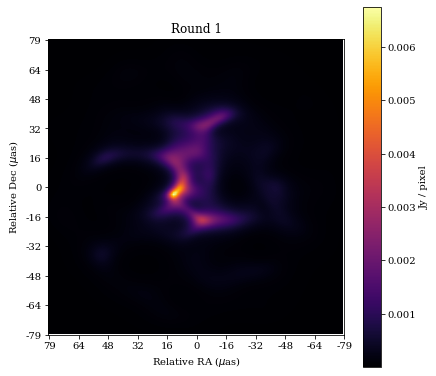

In [28]:
display(out, 'Round 1')

### Round 2

In [29]:
alpha_d = [100.0,
           0.75 * 100.0 * N_psi / N_C]

alpha_s = [1.0,
           50.0,
           50.0,
           50.0]

objfunc = create_objfunc(d, alpha_d, s, alpha_s)
objgrad = create_objgrad(dg, alpha_d, sg, alpha_s)

In [30]:
fblur = 0.75 # The fraction of the maximum resolution to blur by

fwhm    = fblur * array_res                                    # Full width half maximum (FWHM) of Gaussian blurring kernel
std_dev = fwhm / (2 * np.sqrt(np.log(2 * np.sqrt(2)))) / delta # The standard deviation of the Guassian from the FWHM (normalized by delta)
out     = gaussian_filter(out, (std_dev, std_dev))             # The blurred image

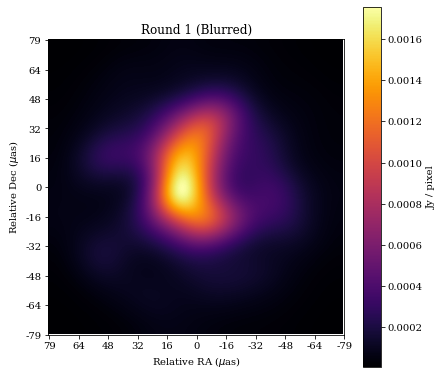

In [31]:
display(out, 'Round 1 (Blurred)')

In [32]:
optdict['maxiter'] = 150 # Set the max iterations to 150
res = minimize(objfunc, np.log(out), method='L-BFGS-B', jac=objgrad, options=optdict, callback=min_update)
out = np.exp(res.x).reshape((m, m)) # The output image
k = 0

Step 0: 107142.713
Step 10: 3583.181
Step 20: 976.742
Step 30: 422.670
Step 40: 292.052
Step 50: 253.167
Step 60: 230.165
Step 70: 218.182
Step 80: 210.577
Step 90: 202.637
Step 100: 189.889


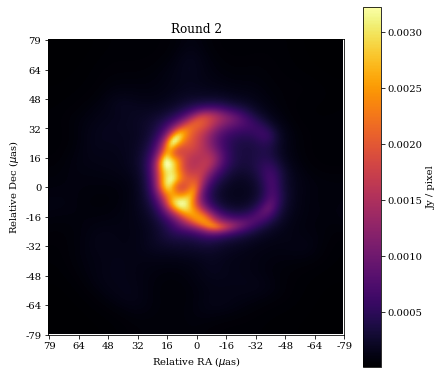

In [33]:
display(out, 'Round 2')

### Round 3

In [34]:
alpha_d = [100.0,
           0.5 * 100.0 * N_psi / N_C]

alpha_s = [1.0,
           100.0,
           10.0,
           10.0]

objfunc = create_objfunc(d, alpha_d, s, alpha_s)
objgrad = create_objgrad(dg, alpha_d, sg, alpha_s)

In [35]:
fblur = 0.5 # The fraction of the maximum resolution to blur by

fwhm    = fblur * array_res                                    # Full width half maximum (FWHM) of Gaussian blurring kernel
std_dev = fwhm / (2 * np.sqrt(np.log(2 * np.sqrt(2)))) / delta # The standard deviation of the Guassian from the FWHM (normalized by delta)
out     = gaussian_filter(out, (std_dev, std_dev))             # The blurred image

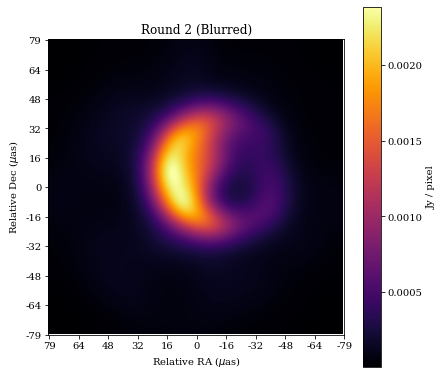

In [36]:
display(out, 'Round 2 (Blurred)')

In [37]:
optdict['maxiter'] = 200 # Set the max iterations to 100
res = minimize(objfunc, np.log(out), method='L-BFGS-B', jac=objgrad, options=optdict, callback=min_update)
out = np.exp(res.x).reshape((m, m)) # The output image
k = 0

Step 0: 16429.972
Step 10: 513.860
Step 20: 119.010
Step 30: 73.969


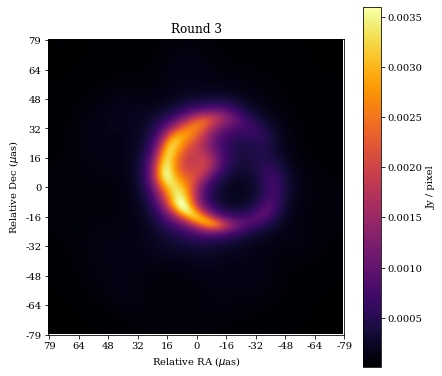

In [38]:
display(out, 'Round 3')

### Round 4

In [39]:
alpha_d = [100.0,
           1 * 100.0 * N_psi / N_C]

alpha_s = [1.0,
           500.0,
           1.0,
           1.0]

objfunc = create_objfunc(d, alpha_d, s, alpha_s)
objgrad = create_objgrad(dg, alpha_d, sg, alpha_s)

In [40]:
fblur = 0.33 # The fraction of the maximum resolution to blur by

fwhm    = fblur * array_res                                    # Full width half maximum (FWHM) of Gaussian blurring kernel
std_dev = fwhm / (2 * np.sqrt(np.log(2 * np.sqrt(2)))) / delta # The standard deviation of the Guassian from the FWHM (normalized by delta)
out     = gaussian_filter(out, (std_dev, std_dev))             # The blurred image

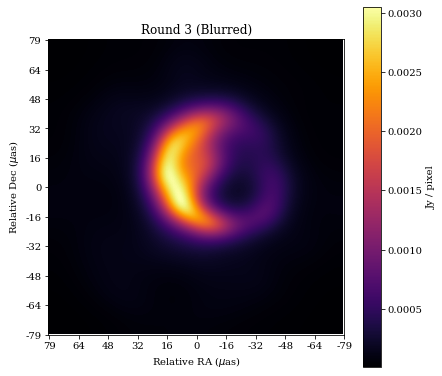

In [41]:
display(out, 'Round 3 (Blurred)')

In [42]:
optdict['maxiter'] = 200 # Set the max iterations to 50
res = minimize(objfunc, np.log(out), method='L-BFGS-B', jac=objgrad, options=optdict, callback=min_update)
out = np.exp(res.x).reshape((m, m)) # The output image
k = 0

Step 0: 1613.749
Step 10: 158.553
Step 20: 45.928
Step 30: 36.456


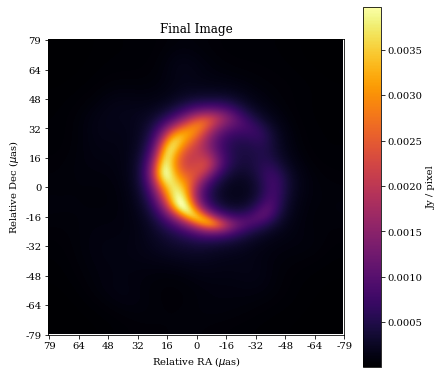

In [43]:
display(out, 'Final Image')